# Reproducing the Oxidation State Assignment Model from Jablonka et al.

This notebook reproduces the key methodology and results from:
**"Using collective knowledge to assign oxidation states of metal cations in metal–organic frameworks"**
([DOI: 10.1038/s41557-021-00717-y](https://doi.org/10.1038/s41557-021-00717-y))

## Table of Contents
1. [Environment Setup](#env)
2. [Load Data](#load)
3. [Featurization](#feat)
4. [Model Training](#train)
5. [Evaluation](#eval)
6. [SHAP Analysis](#shap)

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler
import shap
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import warnings
warnings.filterwarnings('ignore')
import pickle

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


## 2. Load Data 

In [2]:
# Load feature matrix and labels
X = np.load("features_all.npy", allow_pickle=True)
y = np.load("labels_all.npy", allow_pickle=True)

# Load structure names (CSD IDs, optional but useful for later)
names_path = r"E:\Projects\Oxidation_used_data\names_all.pkl"

with open(names_path, "rb") as f:
    names = pickle.load(f)
# Check shape
print("Features shape:", X.shape)
print("Labels shape:", y.shape)
print("Example CSD IDs:", names[:5])

Features shape: (211723, 116)
Labels shape: (211723, 1)
Example CSD IDs: ['DEWQUS', 'RIPPEN', 'CIQHOC', 'WIMWIB', 'EMETUL']


In [3]:
# Load the scaler and scale features
scaler = joblib.load("scaler_0.joblib")
X_scaled = scaler.transform(X)

# Load pretrained voting classifier
model = joblib.load("votingclassifier.joblib")

In [4]:
print(X_scaled.shape)

(211723, 116)


In [5]:
# Predict only the first 1000 oxidation states
y_pred = model.predict(X_scaled[:1000])

# (Optional) Evaluate on first 1000 labels
from sklearn.metrics import classification_report

print(classification_report(y[:1000], y_pred))

              precision    recall  f1-score   support

           1       0.99      1.00      0.99       182
           2       1.00      1.00      1.00       596
           3       1.00      0.99      1.00       163
           4       1.00      1.00      1.00        30
           5       1.00      1.00      1.00         4
           6       1.00      1.00      1.00        25

    accuracy                           1.00      1000
   macro avg       1.00      1.00      1.00      1000
weighted avg       1.00      1.00      1.00      1000



Accuracy: 0.997
              precision    recall  f1-score   support

           1       0.99      1.00      0.99       182
           2       1.00      1.00      1.00       596
           3       1.00      0.99      1.00       163
           4       1.00      1.00      1.00        30
           5       1.00      1.00      1.00         4
           6       1.00      1.00      1.00        25

    accuracy                           1.00      1000
   macro avg       1.00      1.00      1.00      1000
weighted avg       1.00      1.00      1.00      1000



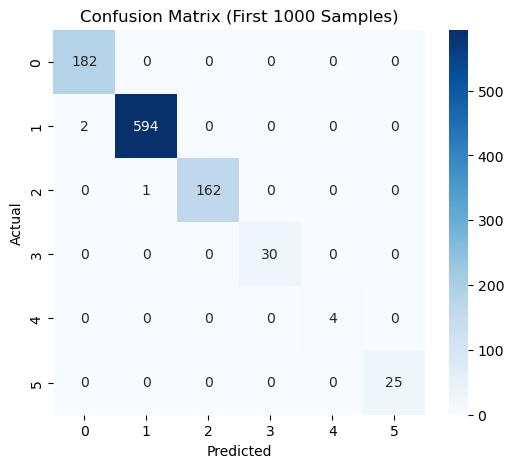

In [6]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# True vs predicted for the first 1000
y_true_1000 = y[:1000]
y_pred_1000 = model.predict(X_scaled[:1000])

# Accuracy
print("Accuracy:", accuracy_score(y_true_1000, y_pred_1000))

# Classification report
print(classification_report(y_true_1000, y_pred_1000))

# Confusion matrix
conf = confusion_matrix(y_true_1000, y_pred_1000)
plt.figure(figsize=(6, 5))
sns.heatmap(conf, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix (First 1000 Samples)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [7]:
df = pd.read_csv(r"E:\Projects\Oxidation_used_data\all_data.csv")
print(df.columns.tolist())

['Unnamed: 0', 'local difference in MendeleevNumber', 'local difference in Column', 'local difference in Row', 'local difference in Electronegativity', 'local difference in NsValence', 'local difference in NpValence', 'local difference in NdValence', 'local difference in NfValence', 'local difference in NValence', 'local difference in NsUnfilled', 'local difference in NpUnfilled', 'local difference in NdUnfilled', 'local difference in NfUnfilled', 'local difference in NUnfilled', 'local difference in GSbandgap', 'local signed difference in MendeleevNumber', 'local signed difference in Column', 'local signed difference in Row', 'local signed difference in Electronegativity', 'local signed difference in NsValence', 'local signed difference in NpValence', 'local signed difference in NdValence', 'local signed difference in NfValence', 'local signed difference in NValence', 'local signed difference in NsUnfilled', 'local signed difference in NpUnfilled', 'local signed difference in NdUnfill

In [9]:
import pandas as pd
import shap

# Load the full dataset from outside the repo
df = pd.read_csv(r"E:\Projects\Oxidation_used_data\all_data.csv")

# Prepare features and labels
X_df_numeric = X_df.select_dtypes(include=["number"])
y_df = df["oxidationstate"]

# Scale (reuse the previously loaded scaler)
X_scaled_df = scaler.transform(X_df_numeric)

# Use the first 100 samples for SHAP
explainer = shap.Explainer(model.estimators_[0], X_scaled_df[:100])
shap_values = explainer(X_scaled_df[:100])

# Show summary plot with feature names
shap.summary_plot(shap_values, X_scaled_df[:100], feature_names=X_df_numeric.columns)

ValueError: operands could not be broadcast together with shapes (1441551,137) (116,) (1441551,137) 